# Setup

In [2]:
%matplotlib inline

import torch
import random
import copy
import requests #for sending updates to my phone via telegram
import numpy as np
import pandas as pd
import seaborn as sns

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

from collections import Counter
from torch.autograd import Variable
from torchvision import datasets, transforms
from operator import itemgetter
from tqdm import tqdm, tnrange, tqdm_notebook



In [1]:
with open(r"D:\TELEGRAM_BOTS\NEURALUPDATES.txt") as file: #Credentials for telegram bot
    BOT_TOKEN, CHANNEL = file.read().split('\n')

## Bokeh and interactive plots

In [60]:
from ipywidgets  import interactive
from bokeh.plotting import figure 
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, WheelZoomTool
from bokeh.layouts import gridplot

output_notebook()
sns.set()

Loading BokehJS ...

# Dataloaders

## Clean MNIST loaders

In [3]:
torch.manual_seed(1);

In [4]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       #transforms.Normalize((0.1307,), (0.3081,)) #normalise pixels using mean and stdev
                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #normalise to range -1 to 1
                   ])



MNIST_train = datasets.MNIST(r'D:\Data_sets/MNIST', train=True, download=True,
                   transform=transform)

MNIST_test = datasets.MNIST(r'D:\Data_sets/MNIST', train=False, download=True,
                   transform=transform)

In [5]:
train_loader = torch.utils.data.DataLoader(MNIST_train, 
                                           batch_size=64, 
                                           shuffle=True, 
                                           pin_memory=True)

test_loader = torch.utils.data.DataLoader(MNIST_test,
                                          batch_size=1000, 
                                          shuffle=True, 
                                          pin_memory=True)

## Adversarial loader

In [6]:
class AdversarialDataset(torch.utils.data.Dataset):
    """FGSM adversarials of MNIST test set"""

    def __init__(self, root_dir, transform=None):

        self.adversarials = np.load(root_dir+'/adversarials.npy')
        self.labels = np.load(root_dir+'/labels.npy')
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        
        image = self.adversarials[idx]
        label = self.labels[idx]

        if self.transform:
            sample = self.transform(sample)

        return image, label

In [7]:
adversarials = AdversarialDataset('D:/Data_sets/Adversarial/MNIST')

In [8]:
adversarial_loader = torch.utils.data.DataLoader(adversarials, 
                                           batch_size=1000, 
                                           shuffle=True, 
                                           pin_memory=True)

# Hyperparameter space

In [9]:
LAYER_SPACE = {
    'nb_units':{'lb': 128, 'ub':2048, 'mutate': 0.15},
    'dropout_rate': {'lb': 0.0, 'ub': 0.7, 'mutate': 0.2},
    'activation': {'func': ['linear','tanh','relu','sigmoid','elu'], 'mutate':0.2}
}

In [10]:
NET_SPACE = {
    'nb_layers': {'lb': 1, 'ub': 3, 'mutate': 0.15},
    'lr': {'lb': 0.001, 'ub':0.1, 'mutate': 0.15},
    'weight_decay': {'lb': 0.00001, 'ub': 0.0004, 'mutate':0.2},
    'optimizer': {'func': ['sgd', 'adam', 'adadelta','rmsprop'], 'mutate': 0.2}
}

# Randomise network

In [11]:
def random_value(space):
    """Returns random value from space."""
    
    val = None
    
    if 'func' in space: #randomise optimiser or activation function
        val = random.sample(space['func'], 1)[0] 
    
    elif isinstance(space['lb'], int): #randomise number of units or layers
        val = random.randint(space['lb'], space['ub'])
    
    else: #randomise percentages, i.e. dropout rates or weight decay
        val = random.random() * (space['ub'] - space['lb']) + space['lb']
    
    return val

In [12]:
def randomize_network(layer_space, net_space): 
    """Returns a randomised neural network"""
    net = {}
    
    for key in net_space.keys():
        net[key] = random_value(net_space[key])
        
    layers = []
    
    for i in range(net['nb_layers']):
        layer = {}
        for key in layer_space.keys():
            layer[key] = random_value(layer_space[key])
        layers.append(layer)
        net['layers'] = layers
        
    return net

In [ ]:
randomize_network(LAYER_SPACE, NET_SPACE)

# Mutate network

In [13]:
def mutate_net(nnet, layer_space, net_space):
    
    net = copy.deepcopy(nnet)
    
    
    # mutate optimizer
    for k in ['lr', 'weight_decay', 'optimizer']:
        if random.random() < net_space[k]['mutate']:
            net[k] = random_value(net_space[k])
    
    
    # mutate layers
    for layer in net['layers']:
        for k in layer_space.keys():
            if random.random() < layer_space[k]['mutate']:
                layer[k] = random_value(layer_space[k])
                
                
    # mutate number of layers -- 50% add 50% remove
    if random.random() < net_space['nb_layers']['mutate']:
        if net['nb_layers'] <= net_space['nb_layers']['ub']:
            if random.random()< 0.5 and \
            net['nb_layers'] < net_space['nb_layers']['ub']:
                layer = {}
                for key in layer_space.keys():
                    layer[key] = random_value(layer_space[key])
                net['layers'].append(layer)      
            else:
                if net['nb_layers'] > 1:
                    net['layers'].pop()

                
            # value & id update
            net['nb_layers'] = len(net['layers'])         
            
    return net

# NetBuilder

In [14]:
class Flatten(nn.Module):
    """Flattens input to vector size (batchsize, 1)
    (for use in NetFromBuildInfo)."""

    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        return x.view(x.size(0), -1)

In [15]:
class NetFromBuildInfo(nn.Module):
    def __init__(self, build_info):
        super(NetFromBuildInfo, self).__init__()
        
        self.activation_dict = {
            'tanh': nn.Tanh(),
            'relu': nn.ReLU(),
            'sigmoid': nn.Sigmoid(),
            'elu': nn.ELU()
            }

        #NETWORK DEFINITION
        
        previous_units = 28 * 28 #MNIST shape
        
        self.model = nn.Sequential()
        self.model.add_module('flatten', Flatten())
         
        for i, layer_info in enumerate(build_info['layers']):
            i = str(i)
            
            self.model.add_module(
                'fc_' + i,
                nn.Linear(previous_units, layer_info['nb_units'])
                )
            
            previous_units = layer_info['nb_units']
            
            self.model.add_module(
                'dropout_' + i,
                nn.Dropout(p=layer_info['dropout_rate'])
                )
            if layer_info['activation'] == 'linear':
                continue #linear activation is identity function
            self.model.add_module(
                layer_info['activation']+ i,
                self.activation_dict[layer_info['activation']])

        self.model.add_module(
            'logits',
            nn.Linear(previous_units, 10) #10 MNIST classes
            )
        
        
        ##OPTIMIZER

        self.opt_args = {#'params': self.model.parameters(),
                 'weight_decay': build_info['weight_decay'],
                 'lr': build_info['lr']
                 }
        
        self.optimizer_dict = {
            'adam': optim.Adam(self.model.parameters(),**self.opt_args),
            'rmsprop': optim.RMSprop(self.model.parameters(),**self.opt_args),
            'adadelta':optim.Adadelta(self.model.parameters(),**self.opt_args),
            'sgd': optim.SGD(self.model.parameters(), **self.opt_args, momentum=0.9) #momentum to train faster
            }

        self.optimizer = self.optimizer_dict[build_info['optimizer']]
        
        
    def forward(self, x):
        x = self.model(x)
        return F.log_softmax(x, dim=1)

In [16]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# Train test helpers

In [26]:
def train(model, train_loader, optimizer, epoch):
    
    model.train(True)
    
    running_loss = 0.0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        
        data, target = Variable(data.cuda()), Variable(target.cuda())
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward() 
        optimizer.step()
        running_loss += loss.item()

    running_loss /= len(train_loader.dataset)    
    
    if epoch % 100 == 0:
        print('Train Epoch: {} \t Loss: {:.6f}'.format(epoch, running_loss ))

In [18]:
def test(model, test_loader, adversarial=False, eps=0.5):
    
    model.train(False)
    
    test_loss = 0
    correct = 0
    
    if adversarial:
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            data= fgsm(model, data, target, eps=eps)
            output = model(data)
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred).cuda()).sum().item()
            test_loss += F.nll_loss(output, target, size_average=False).item()
        
    else:
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.cuda(), target.cuda()
                output = model(data)
                test_loss += F.nll_loss(output, target, size_average=False).item()
                pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    
    return (test_loss, correct)

# FGSM attack

In [19]:
grads = {} #closure for use as a hook in fgsm attack - otherwise gradients can't be obtained for images. 
def save_grad(name):
    def hook(grad):
        grads[name] = grad
    return hook

In [20]:
def fgsm(model, x, y, eps=0.3, x_val_min=0, x_val_max=1, batch=True): #https://arxiv.org/pdf/1412.6572.pdf
    
    x_adv = Variable(x.data, requires_grad=True).cuda() #clean image
    x_adv.register_hook(save_grad('x_adv'))

    h_adv = model(x_adv) #clean pred
    
    cost = F.nll_loss(h_adv, y.cuda()) #negative log loss clean image and clean pred

    if x_adv.grad is not None:
        x_adv.grad.data.fill_(0)

    cost.backward()

    #x_adv.grad.sign_() #take sign of gradients 
    x_adv = x_adv + (eps*grads['x_adv'].sign())
    x_adv = torch.clamp(x_adv, x_val_min, x_val_max)
    
    if batch == False:
        with torch.no_grad():
            h = model(x)
            h_adv = model(x_adv)

        return x_adv, h_adv, h
    
    return x_adv

# Evolution optimiser

In [27]:
class TournamentOptimizer:
    """Define a tournament play selection process."""

    def __init__(self, population_sz, layer_space, net_space, init_fn, mutate_fn, builder_fn,
                 train_fn, test_fn, data_loader, test_loader, adversarial_loader):
        
        self.init_fn = init_fn
        self.layer_space = layer_space
        self.net_space = net_space
        self.mutate_fn = mutate_fn
        self.builder_fn = builder_fn
        self.train = train_fn
        self.test = test_fn
        self.dataloader = data_loader
        self.testloader = test_loader
        self.population_sz = population_sz
        self.adversarials = adversarial_loader
        
        torch.manual_seed(1);
        
        self.genomes = [init_fn(self.layer_space, self.net_space) for i in range(population_sz)]   
        self.population = []
        
        self.test_results = {} 
        self.genome_history = {} 

        self.generation = 0

    def step(self, generations=1, save=True, phone=False):
        """Tournament evolution step."""

        for _ in tnrange(generations, desc='Overall progress'): #tqdm progress bar

            self.generation += 1

            self.genome_history[self.generation] = self.genomes
            self.population = [NetFromBuildInfo(i).cuda() for i in self.genomes]
            self.children = []
            

            self.train_nets(save=save)
            self.evaluate_nets()

            mean = np.mean(self.test_results[self.generation]['correct'])
            best = np.max(self.test_results[self.generation]['correct'])

            tqdm.write('Generation {} Population mean:{} max:{}'
                       .format(self.generation, mean, best))
            
            if phone: #update via telegram
                requests.post("https://api.telegram.org/bot{}/"
                  "sendMessage".format(BOT_TOKEN), 
                  data={'chat_id': '{}'.format(CHANNEL),
                    'text':'Generation {} completed \n'
                        'Population mean: {} max: {}'
                        .format(self.generation, mean, best)})

                
                

            n_elite = 2
            sorted_pop = np.argsort(self.test_results[self.generation]['correct'])[::-1]
            elite = sorted_pop[:n_elite]
            
            # elites always included in the next population
            self.elite = []
            print('\nTop performers:')
            for no, i in enumerate(elite):
                self.elite.append((self.test_results[self.generation]['correct'][i], 
                                   self.population[i]))    

                self.children.append(self.genomes[i])

                tqdm.write("{}: score:{}".format(no,
                            self.test_results[self.generation]['correct'][i]))   




            #https://stackoverflow.com/questions/31933784/tournament-selection-in-genetic-algorithm
            p = 0.85 # winner probability 
            tournament_size = 3
            probs = [p*((1-p)**i) for i in range(tournament_size-1)]
            probs.append(1-np.sum(probs))
            #probs = [0.85, 0.1275, 0.0224]

            while len(self.children) < self.population_sz:
                pop = range(len(self.population))
                sel_k = random.sample(pop, k=tournament_size)
                fitness_k = list(np.array(self.test_results[self.generation]['correct'])[sel_k])
                selected = zip(sel_k, fitness_k)
                rank = sorted(selected, key=itemgetter(1), reverse=True)
                pick = np.random.choice(tournament_size, size=1, p=probs)[0]
                best = rank[pick][0]
                genome = self.mutate_fn(self.genomes[best], self.layer_space, self.net_space)
                self.children.append(genome)
                
            self.genomes = self.children
                

        
        
    def train_nets(self, save=True):
        """trains population of nets"""
         
        for i, net in enumerate(tqdm_notebook(self.population)):
            for epoch in range(1, 11):
                torch.manual_seed(1);
                self.train(net, self.dataloader, net.optimizer, epoch)
                
            if save:
                fp = r"D:\Models\NeuroEvolution/{}-{}".format(self.generation, i)
                torch.save(net.state_dict(), fp)
                
                
    def evaluate_nets(self):
        """evaluate the models."""
        
        losses = []
        corrects = []
        clean_corrects = []
        
        self.test_results[self.generation] = {}
        
        for i in range(len(self.population)):
            net = self.population[i]
            loss, correct = self.test(net, self.testloader, adversarial=True, eps=0.5) 
            _, clean_correct = self.test(net, self.testloader)
            
            losses.append(loss)
            corrects.append(correct)
            clean_corrects.append(clean_correct)
        
        self.test_results[self.generation]['losses'] = losses
        self.test_results[self.generation]['correct'] = corrects
        self.test_results[self.generation]['clean_correct'] = clean_corrects

# Run 

In [30]:
testing2 = TournamentOptimizer(30, LAYER_SPACE, NET_SPACE, randomize_network, 
                           mutate_net, NetFromBuildInfo, train, test,
                          train_loader, test_loader, adversarial_loader)

In [31]:
testing2.step(generations=100, save=True, phone=True)

Generation 1 Population mean:2128.6 max:6936

Top performers:
0: score:6936
1: score:6800


Generation 2 Population mean:3321.6 max:7992

Top performers:
0: score:7992
1: score:7680


Generation 3 Population mean:3999.0666666666666 max:7694

Top performers:
0: score:7694
1: score:7592


Generation 4 Population mean:6130.2 max:8286

Top performers:
0: score:8286
1: score:7943


Generation 5 Population mean:4607.766666666666 max:7839

Top performers:
0: score:7839
1: score:7791


Generation 6 Population mean:4181.166666666667 max:7872

Top performers:
0: score:7872
1: score:7864


Generation 7 Population mean:4803.566666666667 max:8198

Top performers:
0: score:8198
1: score:8115


Generation 8 Population mean:5246.033333333334 max:8115

Top performers:
0: score:8115
1: score:8047


Generation 9 Population mean:5673.4 max:8231

Top performers:
0: score:8231
1: score:7928


Generation 10 Population mean:5204.033333333334 max:8132

Top performers:
0: score:8132
1: score:7840


Generation 11 Population mean:5623.833333333333 max:8342

Top performers:
0: score:8342
1: score:8226


Generation 12 Population mean:5680.933333333333 max:8485

Top performers:
0: score:8485
1: score:8368


Generation 13 Population mean:5712.566666666667 max:8522

Top performers:
0: score:8522
1: score:8269


Generation 14 Population mean:6048.333333333333 max:8522

Top performers:
0: score:8522
1: score:8361


Generation 15 Population mean:6514.166666666667 max:8522

Top performers:
0: score:8522
1: score:8366


Generation 16 Population mean:5864.566666666667 max:8522

Top performers:
0: score:8522
1: score:8270


Generation 17 Population mean:5680.4 max:8522

Top performers:
0: score:8522
1: score:8368


Generation 18 Population mean:5080.566666666667 max:8522

Top performers:
0: score:8522
1: score:8343


Generation 19 Population mean:4706.233333333334 max:8522

Top performers:
0: score:8522
1: score:8243


Generation 20 Population mean:5528.466666666666 max:8522

Top performers:
0: score:8522
1: score:8250


Generation 21 Population mean:5112.533333333334 max:8522

Top performers:
0: score:8522
1: score:8412


Generation 22 Population mean:5732.7 max:8522

Top performers:
0: score:8522
1: score:8505


Generation 23 Population mean:5515.366666666667 max:8544

Top performers:
0: score:8544
1: score:8522


Generation 24 Population mean:5552.2 max:8401

Top performers:
0: score:8401
1: score:8342


Generation 25 Population mean:5539.566666666667 max:8394

Top performers:
0: score:8394
1: score:8216


Generation 26 Population mean:5307.3 max:8268

Top performers:
0: score:8268
1: score:8251


Generation 27 Population mean:5534.3 max:8367

Top performers:
0: score:8367
1: score:8362


Generation 28 Population mean:6052.9 max:8288

Top performers:
0: score:8288
1: score:8270


Generation 29 Population mean:5640.966666666666 max:8455

Top performers:
0: score:8455
1: score:8391


Generation 30 Population mean:6190.766666666666 max:8407

Top performers:
0: score:8407
1: score:8342


Generation 31 Population mean:6082.533333333334 max:8460

Top performers:
0: score:8460
1: score:8337


Generation 32 Population mean:6602.6 max:8479

Top performers:
0: score:8479
1: score:8410


Generation 33 Population mean:5637.5 max:8481

Top performers:
0: score:8481
1: score:8342


Generation 34 Population mean:6144.633333333333 max:8297

Top performers:
0: score:8297
1: score:8148


Generation 35 Population mean:6427.166666666667 max:8384

Top performers:
0: score:8384
1: score:8275


Generation 36 Population mean:7486.0 max:8378

Top performers:
0: score:8378
1: score:8319


Generation 37 Population mean:6759.266666666666 max:8329

Top performers:
0: score:8329
1: score:8277


Generation 38 Population mean:5764.1 max:8575

Top performers:
0: score:8575
1: score:8435


Generation 39 Population mean:5292.333333333333 max:8365

Top performers:
0: score:8365
1: score:8289


Generation 40 Population mean:5811.0 max:8384

Top performers:
0: score:8384
1: score:8336


Generation 41 Population mean:5420.433333333333 max:8501

Top performers:
0: score:8501
1: score:8378


Generation 42 Population mean:4499.033333333334 max:8351

Top performers:
0: score:8351
1: score:8342


Generation 43 Population mean:5579.766666666666 max:8370

Top performers:
0: score:8370
1: score:8275


Generation 44 Population mean:5392.466666666666 max:8444

Top performers:
0: score:8444
1: score:8370


Generation 45 Population mean:5114.666666666667 max:8307

Top performers:
0: score:8307
1: score:8268


Generation 46 Population mean:6038.533333333334 max:8408

Top performers:
0: score:8408
1: score:8370


Generation 47 Population mean:6048.466666666666 max:8370

Top performers:
0: score:8370
1: score:8290


Generation 48 Population mean:7047.833333333333 max:8370

Top performers:
0: score:8370
1: score:8326


Generation 49 Population mean:5888.733333333334 max:8404

Top performers:
0: score:8404
1: score:8370


Generation 50 Population mean:5610.666666666667 max:8357

Top performers:
0: score:8357
1: score:8339


Generation 51 Population mean:4823.0 max:8358

Top performers:
0: score:8358
1: score:8284


Generation 52 Population mean:5814.7 max:8390

Top performers:
0: score:8390
1: score:8296


Generation 53 Population mean:5812.233333333334 max:8521

Top performers:
0: score:8521
1: score:8331


Generation 54 Population mean:5075.0 max:8292

Top performers:
0: score:8292
1: score:8257


Generation 55 Population mean:5365.133333333333 max:8536

Top performers:
0: score:8536
1: score:8460


Generation 56 Population mean:6051.1 max:8322

Top performers:
0: score:8322
1: score:8311


Generation 57 Population mean:6744.9 max:8465

Top performers:
0: score:8465
1: score:8372


Generation 58 Population mean:5397.2 max:8408

Top performers:
0: score:8408
1: score:8168


Generation 59 Population mean:5961.566666666667 max:8440

Top performers:
0: score:8440
1: score:8293


Generation 60 Population mean:6133.366666666667 max:8567

Top performers:
0: score:8567
1: score:8449


Generation 61 Population mean:6846.066666666667 max:8478

Top performers:
0: score:8478
1: score:8431


Generation 62 Population mean:6036.733333333334 max:8478

Top performers:
0: score:8478
1: score:8375


Generation 63 Population mean:5945.266666666666 max:8490

Top performers:
0: score:8490
1: score:8478


Generation 64 Population mean:6785.266666666666 max:8426

Top performers:
0: score:8426
1: score:8377


Generation 65 Population mean:5855.666666666667 max:8478

Top performers:
0: score:8478
1: score:8416


Generation 66 Population mean:5724.1 max:8559

Top performers:
0: score:8559
1: score:8478


Generation 67 Population mean:5958.6 max:8481

Top performers:
0: score:8481
1: score:8478


Generation 68 Population mean:5184.866666666667 max:8577

Top performers:
0: score:8577
1: score:8546


Generation 69 Population mean:5724.133333333333 max:8426

Top performers:
0: score:8426
1: score:8405


Generation 70 Population mean:5154.7 max:8428

Top performers:
0: score:8428
1: score:8327


Generation 71 Population mean:5695.233333333334 max:8408

Top performers:
0: score:8408
1: score:8347


Generation 72 Population mean:6629.4 max:8430

Top performers:
0: score:8430
1: score:8429


Generation 73 Population mean:5782.1 max:8505

Top performers:
0: score:8505
1: score:8454


Generation 74 Population mean:5470.866666666667 max:8466

Top performers:
0: score:8466
1: score:8417


Generation 75 Population mean:6322.2 max:8552

Top performers:
0: score:8552
1: score:8318


Generation 76 Population mean:6436.933333333333 max:8548

Top performers:
0: score:8548
1: score:8538


Generation 77 Population mean:6748.4 max:8525

Top performers:
0: score:8525
1: score:8501


Generation 78 Population mean:6293.866666666667 max:8377

Top performers:
0: score:8377
1: score:8274


Generation 79 Population mean:6852.7 max:8487

Top performers:
0: score:8487
1: score:8425


Generation 80 Population mean:6403.3 max:8317

Top performers:
0: score:8317
1: score:8219


Generation 81 Population mean:5912.166666666667 max:8317

Top performers:
0: score:8317
1: score:8315


Generation 82 Population mean:6001.566666666667 max:8236

Top performers:
0: score:8236
1: score:8219


Generation 83 Population mean:5196.066666666667 max:8287

Top performers:
0: score:8287
1: score:8179


Generation 84 Population mean:6015.866666666667 max:8390

Top performers:
0: score:8390
1: score:8356


Generation 85 Population mean:5463.4 max:8181

Top performers:
0: score:8181
1: score:8162


Generation 86 Population mean:5879.866666666667 max:8263

Top performers:
0: score:8263
1: score:8247


Generation 87 Population mean:5450.333333333333 max:8269

Top performers:
0: score:8269
1: score:8219


Generation 88 Population mean:6161.0 max:8425

Top performers:
0: score:8425
1: score:8281


Generation 89 Population mean:5356.866666666667 max:8295

Top performers:
0: score:8295
1: score:8292


Generation 90 Population mean:5620.566666666667 max:8381

Top performers:
0: score:8381
1: score:8291


Generation 91 Population mean:5549.8 max:8441

Top performers:
0: score:8441
1: score:8269


Generation 92 Population mean:6130.566666666667 max:8271

Top performers:
0: score:8271
1: score:8225


Generation 93 Population mean:5548.033333333334 max:8321

Top performers:
0: score:8321
1: score:8271


Generation 94 Population mean:5565.266666666666 max:8448

Top performers:
0: score:8448
1: score:8222


Generation 95 Population mean:6748.033333333334 max:8343

Top performers:
0: score:8343
1: score:8318


Generation 96 Population mean:5736.5 max:8395

Top performers:
0: score:8395
1: score:8313


Generation 97 Population mean:5930.1 max:8458

Top performers:
0: score:8458
1: score:8386


Generation 98 Population mean:6709.433333333333 max:8343

Top performers:
0: score:8343
1: score:8263


Generation 99 Population mean:6576.9 max:8366

Top performers:
0: score:8366
1: score:8280


Generation 100 Population mean:6868.366666666667 max:8405

Top performers:
0: score:8405
1: score:8292



# Progress plots

## Plot func definitions 

In [32]:
def progressplotter(optimizer, clean=False):
    
    if clean:
        dataset = 'clean_correct'
    else:
        dataset = 'correct'
    
    means = []
    
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)
    
    gens = range(len(optimizer.test_results))
    popsize = len(optimizer.test_results[1][dataset])
    
    for i in gens:
        ax.scatter([i for j in range(popsize)], optimizer.test_results[i+1][dataset])
        mean = np.mean(optimizer.test_results[i+1][dataset])
        means.append(mean)
        ax.scatter(i, mean, c=1)
        
        if i == 0:
            continue
        plt.plot([i-1, i], [means[i-1], mean], c='black')
        
    ax.set_xticks(np.arange(0, len(means),1))
    ax.set_xlabel('Generation')
    ax.set_ylabel('Correct classifications')
    
    if clean:
        ax.set_title('Accuracy on clean dataset')
    else:
        ax.set_title('Accuracy on adversarial dataset')
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

In [33]:
def diffplotter(optimizer):
    diff = {}
    for gen in optimizer.test_results:
        diff[gen] = []
        for i in range(len(optimizer.test_results[gen]['clean_correct'])):
            clean = optimizer.test_results[gen]['clean_correct'][i]
            adver = optimizer.test_results[gen]['correct'][i]
            diff[gen].append(clean - adver)
            
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111)

    gens = len(optimizer.test_results)
    popsize = len(optimizer.test_results[gen]['clean_correct'])

    for i in range(gens):
        ax.scatter([i for j in range(popsize)], diff[i+1])
        
    ax.set_title('Difference between clean and adversarial accuracy')
    ax.set_xlabel('Generation')
    ax.set_ylabel('Clean accuracy - adversarial accuracy')
    
    ax.set_xticks(np.arange(0, gens,1))
    
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label]):
        item.set_fontsize(30)
        
    for item in (ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(15)

In [34]:
def bestplotter(optimizer, k=0):

    holder = {
        'clean accuracy' : [],
        'adversarial accuracy' : [],
        'number of layers' : [],
        'activation function' : [],
        'dropout rate' : [],
        'optimizer' : [],
        'number of units in layer' : [],
        'learning rate' : [],
    }

    for gen in optimizer.test_results:

        curr = optimizer.test_results[gen]

        best_index = np.argsort(curr['correct'])[::-1][k]

        holder['clean accuracy'].append(curr['clean_correct'][best_index])
        holder['adversarial accuracy'].append(curr['correct'][best_index])

        genome = optimizer.genome_history[gen][best_index]

        holder['number of layers'].append(genome['nb_layers'])
        holder['dropout rate'].append(genome['layers'][0]['dropout_rate'])
        holder['number of units in layer'].append(genome['layers'][0]['nb_units'])
        holder['optimizer'].append(genome['optimizer'])
        holder['activation function'].append(genome['layers'][0]['activation'])
        holder['learning rate'].append(genome['lr'])
        
    gens = len(holder['clean accuracy'])
    
    fig = plt.figure(figsize=(20,20))
    
    for i in range(8):
        ax = fig.add_subplot(4,2, i+1)
        ax.set_ylabel(list(holder.keys())[i])
        ax.set_xlabel('Generation')
        ax.set_xticks(np.arange(0, gens,5))
        ax.yaxis.label.set_fontsize(15)
        
        
        
        for j in range(gens):
            ax.scatter(j, holder[list(holder.keys())[i]][j], c='black')

In [35]:
def avgplotter(optimizer):

    holder = {
        'clean accuracy' : [],
        'adversarial accuracy' : [],
        'number of layers' : [],
        'activation function' : [],
        'dropout rate' : [],
        'optimizer' : [],
        'number of units in layer' : [],
        'learning rate' : [],
    }

    for gen in optimizer.test_results:

        curr = optimizer.test_results[gen]
        genomes = optimizer.genome_history[gen]
        
        templist1 = []
        templist2 = []
        templist3 = []
        templist4 = []
        templist5 = []
        templist6 = []
        for net in genomes:
            templist1.append(net['nb_layers'])
            templist2.append(net['optimizer'])
            templist3.append(net['lr'])
            templist4.append(net['layers'][0]['dropout_rate'])
            templist5.append(net['layers'][0]['nb_units'])
            templist6.append(net['layers'][0]['activation'])
            
            
        holder['number of layers'].append(np.mean(templist1))
        holder['optimizer'].append(Counter(templist2).most_common()[0][0])
        holder['learning rate'].append(np.mean(templist3))
        holder['dropout rate'].append(np.mean(templist4))
        holder['number of units in layer'].append(np.mean(templist5))
        holder['activation function'].append(Counter(templist6).most_common()[0][0])
        

        holder['clean accuracy'].append(np.mean(curr['clean_correct']))
        holder['adversarial accuracy'].append(np.mean(curr['correct']))
            

    gens = len(holder['clean accuracy'])
    
    fig = plt.figure(figsize=(20,20))
    
    for i in range(8):
        ax = fig.add_subplot(4,2, i+1)
        ax.set_ylabel(list(holder.keys())[i])
        ax.set_xlabel('Generation')
        ax.set_xticks(np.arange(0, gens,5))
        ax.yaxis.label.set_fontsize(15)
        
        for j in range(gens):
            ax.scatter(j, holder[list(holder.keys())[i]][j], c='black')

## Plots 

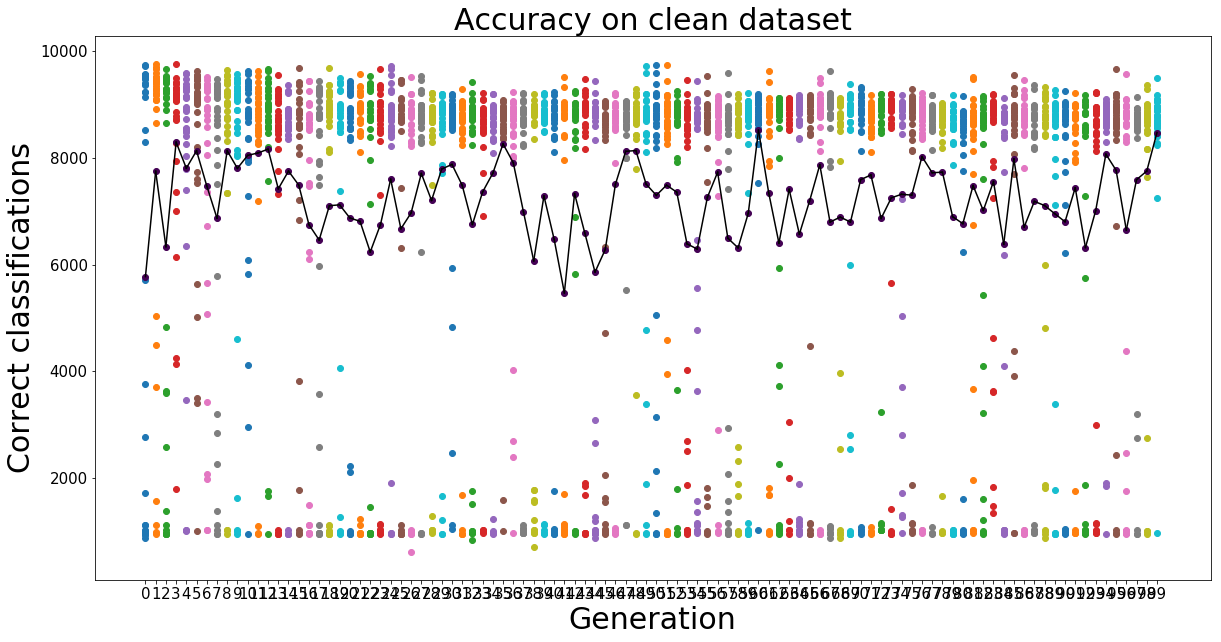

In [36]:
progressplotter(testing2, clean=True)

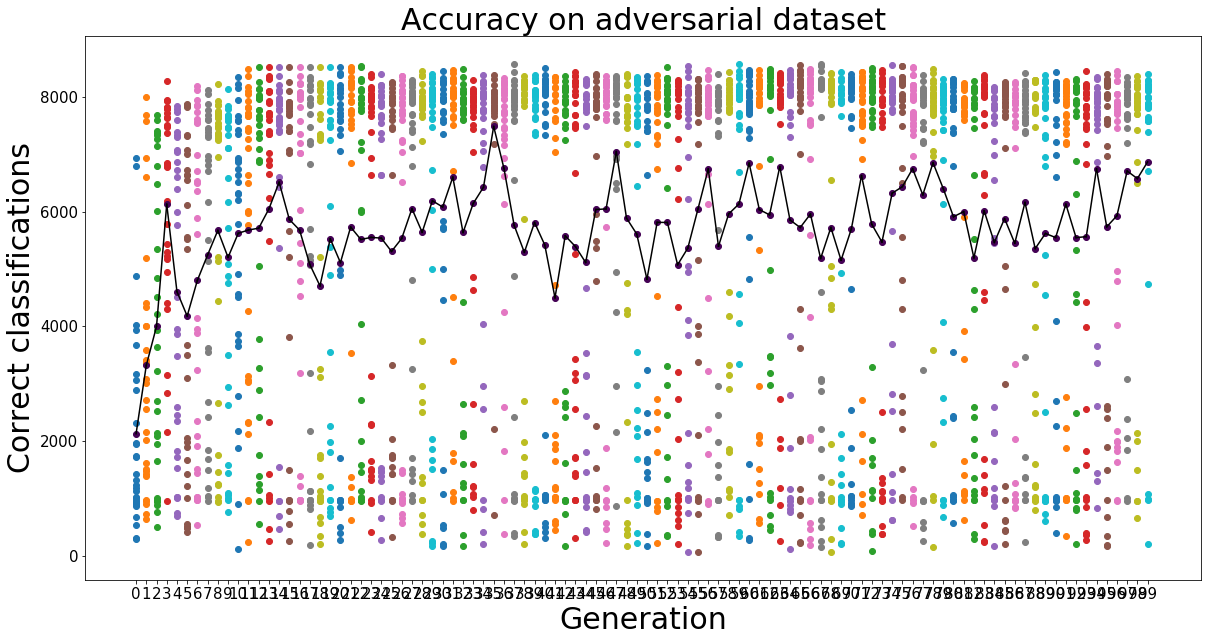

In [37]:
progressplotter(testing2)

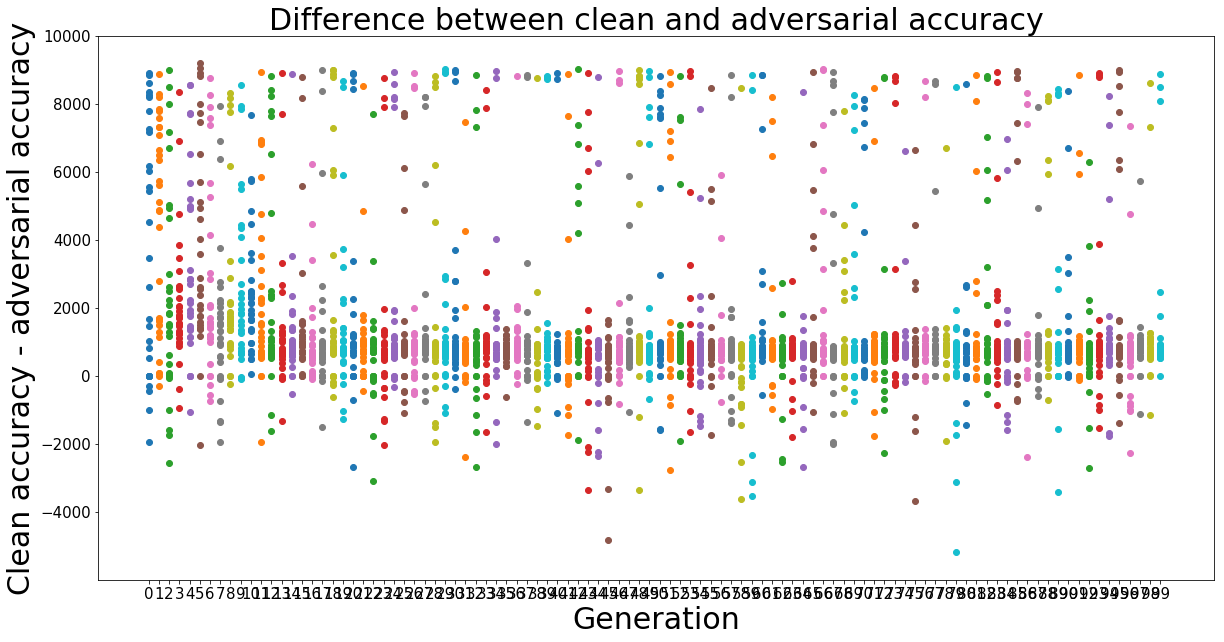

In [38]:
diffplotter(testing2)

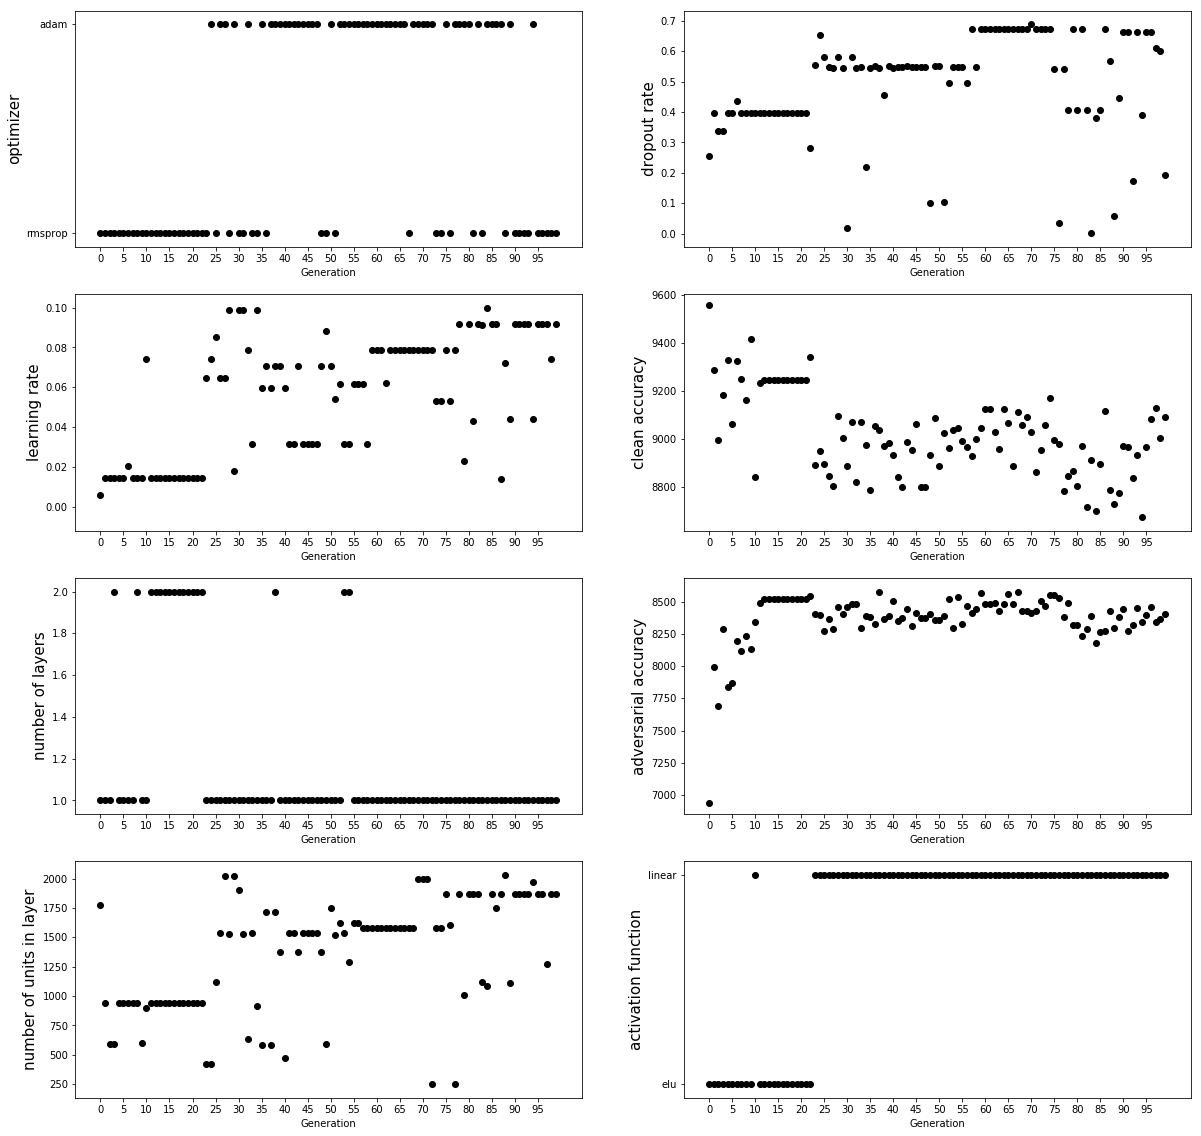

In [39]:
bestplotter(testing2, k=0)

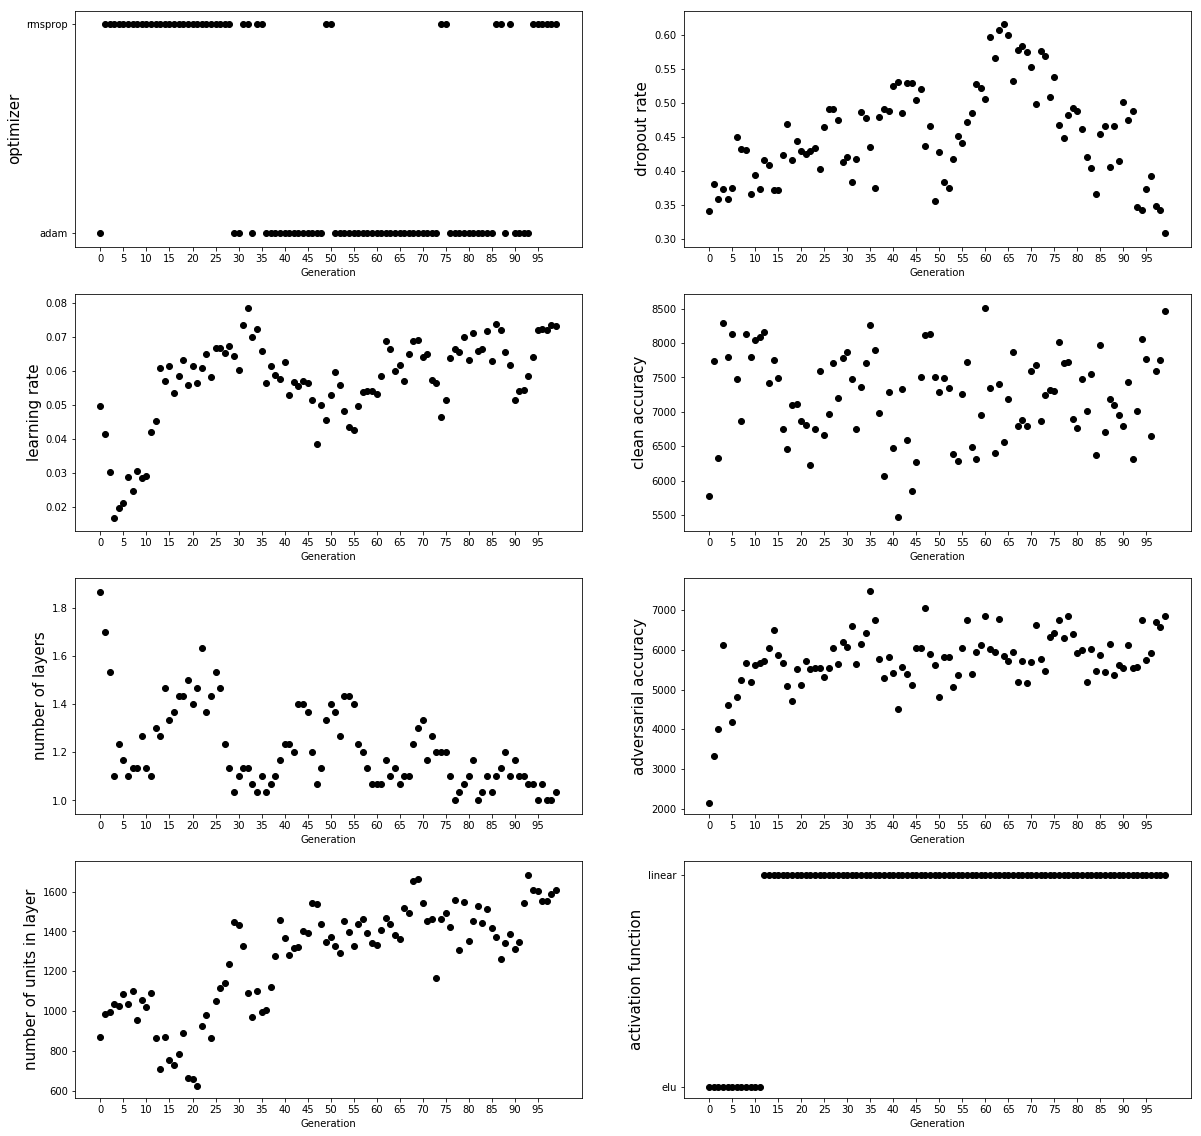

In [40]:
avgplotter(testing2)

# Tests

In [45]:
def rebuild_from_save(optimizer, generation, position):
    
    genome = optimizer.genome_history[generation][position]
    
    net = NetFromBuildInfo(genome)
    
    net.load_state_dict(torch.load(r"D:\Models\NeuroEvolution\{}-{}".format(generation, position)))
    
    return net.cuda()

In [ ]:
def sanity_check(optimizer, test_loader):
    
    for generation in optimizer.test_results:
        print('generation {}: \n'.format(generation))
        for i, result in enumerate(optimizer.test_results[generation]['correct']):
            
            mod = rebuild_from_save(optimizer, generation, i)
            _, rebuild_result = test(mod, test_loader, adversarial=True, eps=0.5)
            
            if result == rebuild_result:
                print("result = {}, rebuild result = {}. (equal)".format(result, rebuild_result))
            else:
                print("result = {}, rebuild result = {}. (different!!)".format(result, rebuild_result))

In [ ]:
sanity_check(testing2, test_loader)

# Best model plots 

## Definitions

In [41]:
def get_best_model(optimizer, adversarial=True):
    current_best = 0
    for i, gen in enumerate(optimizer.test_results):
        if adversarial: 
            generation_correct = optimizer.test_results[gen]['correct']
        else:
            generation_correct = optimizer.test_results[gen]['clean_correct']
        for j, score in enumerate(generation_correct):
            if score > current_best:
                best_gen = gen
                best_pos = j
                current_best = score
    clean_score = optimizer.test_results[best_gen]['clean_correct'][best_pos]
    adv_score = optimizer.test_results[best_gen]['correct'][best_pos]
                
    return [best_gen, clean_score, adv_score, rebuild_from_save(optimizer, best_gen, best_pos)]

In [42]:
def best_printer(optimizer):
    holdict = {}
    holdict['best_clean'] = {}
    holdict['best_adversarial'] = {}
    
    holdict['best_clean']['generation'] , \
    holdict['best_clean']['clean'], \
    holdict['best_clean']['adversarial'], _ = get_best_model(testing2, adversarial=False)
    
    holdict['best_adversarial']['generation'] , \
    holdict['best_adversarial']['clean'], \
    holdict['best_adversarial']['adversarial'], _ = get_best_model(testing2, adversarial=True)
    
    return pd.DataFrame(holdict).T

In [43]:
def multi_plot(optimizer, data_loader, adversarial=False, eps=0.5):
    
    best_gen, best_clean_score, best_adv_score, best_model = get_best_model(optimizer)
    batch = next(iter(data_loader))
    
    print("Showing best model which was found in generation {}\n"
          "Clean accuracy = {}\nadversarial accuracy ={}\n\n"
         "Model: \n\n".format(best_gen, best_clean_score,
                           best_adv_score), best_model, "\n\n",
          "Images below are {}"
          .format('adversarial' if adversarial else 'clean'))

    fig = plt.figure(figsize=(20,20))

    counter=0
    for i in range(len(batch[1])):
        if batch[1][i].item() == counter:
            #do stuff
            counter+=1
            if counter == 10: break
            ax = fig.add_subplot(3,3, counter)
            if adversarial:
                image, _, _ = fgsm(best_model, batch[0][i].view(1,1,28,28).cuda(),
                                   batch[1][i].view(1), eps=eps, batch=False)      
            else:
                image = batch[0][i]
            softmax = F.softmax(best_model(image.view(1,1,28,28).cuda()), dim=1)
            prediction = softmax.argmax()
            prediction_pct = softmax.max()
            ax.imshow(image.detach().cpu().numpy().reshape(28,28))
            ax.text(x=3, y=31, s="Predicted: {x} ({y:.2f})"
                     .format(x=prediction, y=prediction_pct), fontsize=20)

## Plots

In [46]:
best_printer(testing2)

,adversarial,clean,generation
best_adversarial,8577,9112,68
best_clean,3088,9755,2


Showing best model which was found in generation 68
Clean accuracy = 9112
adversarial accuracy =8577

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1577, bias=True)
    (dropout_0): Dropout(p=0.6736020681051939)
    (logits): Linear(in_features=1577, out_features=10, bias=True)
  )
) 

 Images below are adversarial


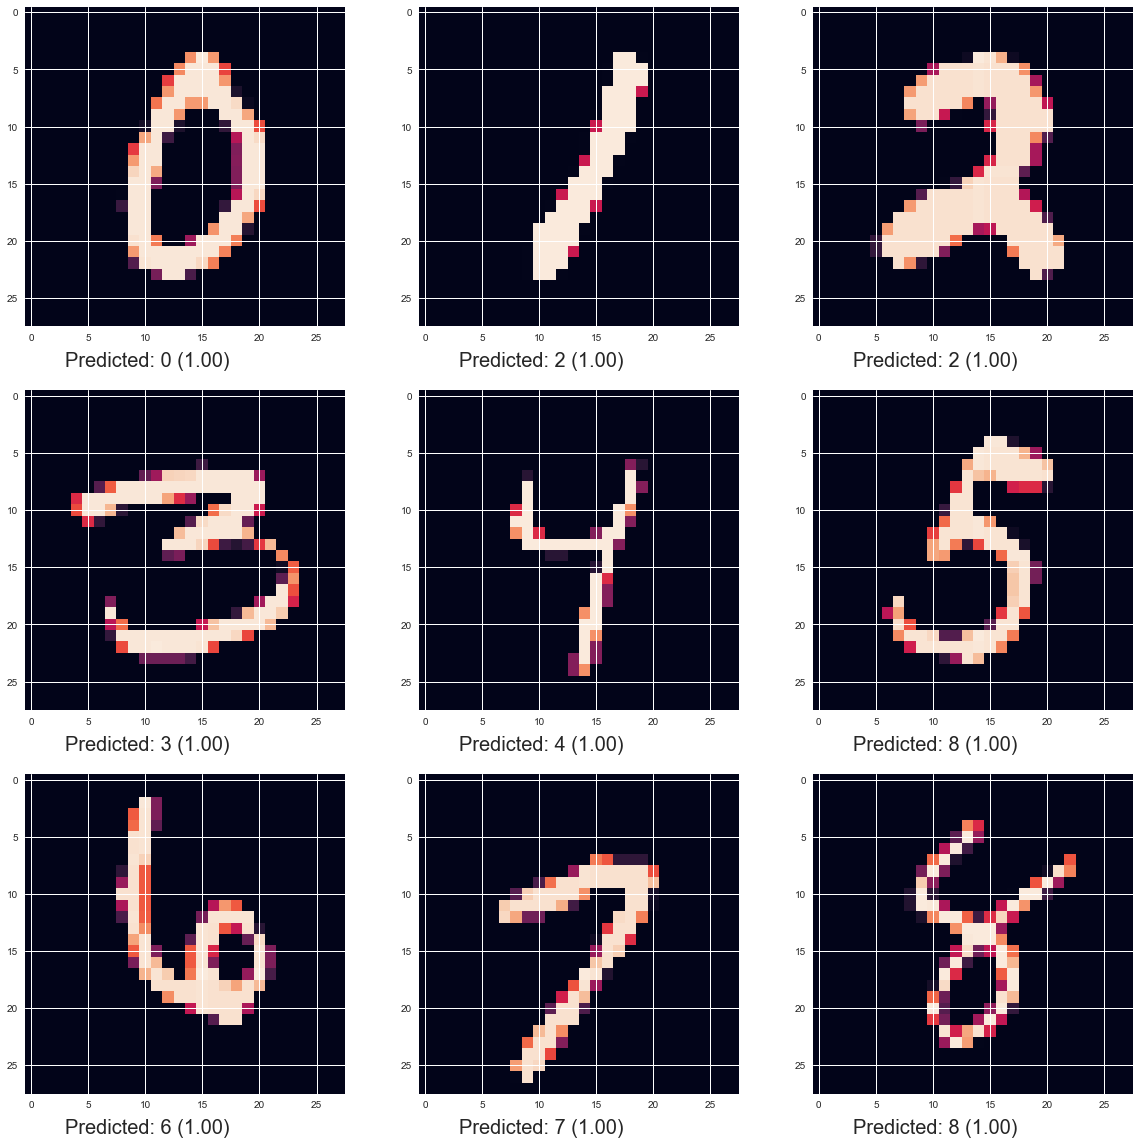

In [68]:
multi_plot(testing2, test_loader, adversarial=True, eps=0.5)

Showing best model which was found in generation 68
Clean accuracy = 9112
adversarial accuracy =8577

Model: 

 NetFromBuildInfo(
  (model): Sequential(
    (flatten): Flatten()
    (fc_0): Linear(in_features=784, out_features=1577, bias=True)
    (dropout_0): Dropout(p=0.6736020681051939)
    (logits): Linear(in_features=1577, out_features=10, bias=True)
  )
) 

 Images below are clean


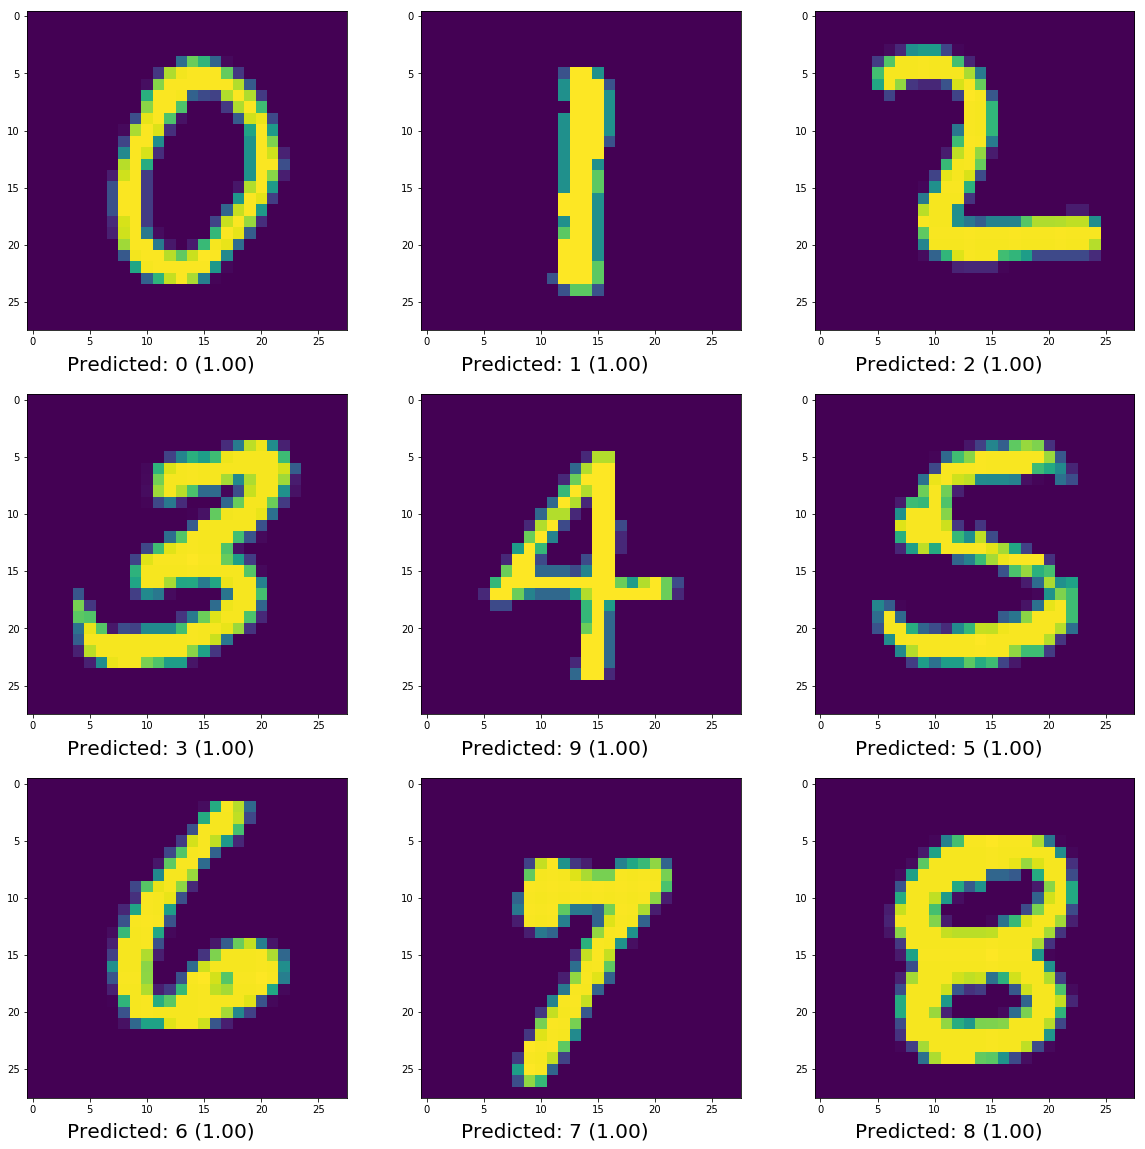

In [48]:
multi_plot(testing2, test_loader, adversarial=False)

# Comparison plots

## Definitions 

In [49]:
_,_,_, best_model = get_best_model(testing2)

In [64]:
eps_dict = {}

for i in tqdm_notebook(range(101)):
    eps_dict[i/100] = test(best_model, test_loader, adversarial = True, eps=i/100)[1]

In [65]:
df =pd.DataFrame(eps_dict, index=['Accuracy']).T
df.index.name = 'epsilon'
df = df.reset_index()

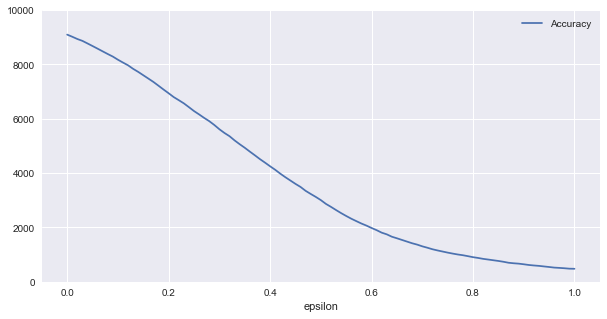

In [66]:
df.plot('epsilon', figsize=(10,5), ylim=[0,10000])

## bokeh progress 

In [54]:
def dataframer(optimizer):
    
    number_of_layers = []
    learning_rate = []
    act_func = []
    number_of_units_1 = []
    dropout_rate = []
    genome_hist = []
    generations = []
    clean_scores = []
    adv_scores = []
    
    for generation in optimizer.test_results:

        scores = optimizer.test_results[generation]
        genomes = optimizer.genome_history[generation]

        clean_scores += scores['clean_correct']
        adv_scores += scores['correct']

        for genome in genomes:
            
            generations.append(generation)
            genome_hist.append(genome)
            number_of_layers.append(genome['nb_layers'])
            learning_rate.append(genome['lr'])

            act_func.append(genome['layers'][0]['activation'])
            number_of_units_1.append(genome['layers'][0]['nb_units'])
            dropout_rate.append(genome['layers'][0]['dropout_rate'])

            df = pd.DataFrame([generations, clean_scores, adv_scores, number_of_layers,
                             learning_rate, act_func, 
                             number_of_units_1, dropout_rate, genome_hist]).T

            df.columns = ['Generation', 'Clean','Adversarial','No_layers',
                          'Lr', 'Act_func', 'Nb_units', 'Dropout', 'Genome']
    
    return df

In [55]:
df = dataframer(testing2)

In [56]:
df.to_pickle(r"../data/neuroevolution2")

In [ ]:
df = pd.read_pickle(r"../data/neuroevolution1")

In [57]:
df

,Generation,Clean,Adversarial,No_layers,Lr,Act_func,Nb_units,Dropout,Genome
0,1,1009,1009,2,0.09106,sigmoid,1995,0.689001,"{'optimizer': 'adam', 'layers': [{'dropout_rat..."
1,1,9133,911,1,0.00123225,sigmoid,228,0.148969,"{'optimizer': 'sgd', 'layers': [{'dropout_rate..."
2,1,9707,1426,1,0.0727381,relu,281,0.0714373,"{'optimizer': 'adadelta', 'layers': [{'dropout..."
3,1,2767,1723,3,0.0991809,relu,712,0.470564,"{'optimizer': 'sgd', 'layers': [{'dropout_rate..."
4,1,1735,1183,1,0.0276198,relu,1525,0.00101077,"{'optimizer': 'rmsprop', 'layers': [{'dropout_..."
5,1,9734,3684,2,0.0153679,linear,259,0.408152,"{'optimizer': 'sgd', 'layers': [{'dropout_rate..."
6,1,1135,313,2,0.0292699,relu,286,0.528861,"{'optimizer': 'adam', 'layers': [{'dropout_rat..."
7,1,958,1942,1,0.0945907,tanh,187,0.262436,"{'optimizer': 'adam', 'layers': [{'dropout_rat..."
8,1,3773,286,1,0.0796346,elu,722,0.314222,"{'optimizer': 'adam', 'layers': [{'dropout_rat..."
9,1,9358,3171,2,0.0354564,tanh,394,0.390624,"{'optimizer': 'sgd', 'layers': [{'dropout_rate..."


In [58]:
def f(x, y, x2, y2, gen):
    if gen == 'all':
        source = ColumnDataSource(df.iloc[:, :-1])#last column contains dicts which causes bokeh to fail
    else: 
        source = ColumnDataSource(df[df['Generation']==gen].iloc[:, :-1]) 
    
    tiplist = [("Accuracy", "@Clean"), 
            ("Adversarial accuracy", "@Adversarial"),
            ("Number of layers", "@No_layers"),
            ("Generation", "@Generation"),
            ("Activation function", "@Act_func"),
              ("Dropout", "@Dropout")]
    
    options = dict(plot_width=400, plot_height=400,
                   tools="pan,wheel_zoom,box_zoom,box_select,lasso_select",
                  active_scroll= 'wheel_zoom')

    p1 = figure(title="{} vs {}".format(y, x), **options)
    p1.scatter(x, y, color="blue", source=source,
               hover_line_color="black", radius=0.1)
    p1.xaxis.axis_label = x
    p1.yaxis.axis_label = y
    if y in ['Adversarial', 'Clean']:
        p1.y_range.start = -1000
        p1.y_range.end = 11000
    p1.add_tools(HoverTool(tooltips=tiplist))

    p2 = figure(title="{} vs {}".format(y2, x2), **options)
    p2.scatter(x2, y2, color="green", source=source, 
               hover_line_color="black", radius=0.1)
    p2.xaxis.axis_label = x2
    p2.yaxis.axis_label = y2
    if y2 in ['Adversarial', 'Clean']:
        p2.y_range.start = -1000
        p2.y_range.end = 11000
    p2.add_tools(HoverTool(tooltips=tiplist))

    p = gridplot([[ p1, p2]], toolbar_location="left")

    show(p)

In [61]:
opts = df.columns.tolist()[:-1] #last column contains dicts which causes bokeh to fail
gen_opts = ['all'] + df['Generation'].unique().tolist() 
y1_opts = opts[2:] + opts[:2]
y2_opts = opts[1:] + opts[:1]
interactive_plot = interactive(f, x=opts, y=y1_opts, x2=opts, y2=y2_opts, gen=gen_opts)

In [62]:
interactive_plot

interactive(children=(Dropdown(description='x', options=('Generation', 'Clean', 'Adversarial', 'No_layers', 'L…